# End to End XGBoost

https://github.com/mattharrison/talks

©2023 MetaSnake

`@__mharrison__`

## Libraries
We will also use SHAP, xgbfir, openpyxl, hyperopt

In [ ]:
# for colab
!pip install dtreeviz feature_engine pybaobabdt xgbfir shap

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'

In [2]:
import feature_engine
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

In [3]:
for mod in [xgb, sklearn, yellowbrick, feature_engine]:
    print(f'{str(mod)[9:20]} {mod.__version__}')

xgboost' fr 2.0.1
sklearn' fr 1.3.2
yellowbrick 1.5
feature_eng 1.5.2


## Datasets

I'll be demoing with Kaggle 2018 survey data


In [4]:
import os
local = 'kaggle-survey-2018.zip'
if not os.path.exists(local):
    url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(local, mode='wb') as fout:
        fout.write(data)
with zipfile.ZipFile(local) as z:
    print(z.namelist())
    kag = pd.read_csv(z.open('multipleChoiceResponses.csv'))
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]

['multipleChoiceResponses.csv', 'freeFormResponses.csv', 'SurveySchema.csv']


/var/folders/qn/r8_0pgj1645dn1w69vqls6cw0000gn/T/ipykernel_6729/1969856928.py:11: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open('multipleChoiceResponses.csv'))


In [5]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

def tweak_kag(df):
    return (df
        #.query('Q3.isin(["United States of America", "China", "India"]) '\
        #       'and Q6.isin(["Data Scientist", "Software Engineer"])')
        .loc[df.Q3.isin(["United States of America", "China", "India"]) &
             df.Q6.isin(["Data Scientist", "Software Engineer"])]
        .pipe(lambda df_:
            df_.assign(**(df_.Q1.pipe(pd.get_dummies, drop_first=True, prefix='gender')),
                       age=df_.Q2.str.slice(0,2).astype(int),
                       **(df_.Q3.pipe(pd.get_dummies, drop_first=True, prefix='country')),
                       education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
                         'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                       **(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                              .pipe(pd.get_dummies, drop_first=True, prefix='major')),
                       title=df_.Q6,
                       years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                       compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation', '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                       python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                       r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                       sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
              
        )#pipe
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'gender_Male':]   
        .dropna()
       )
kag = tweak_kag(raw)
kag_X = kag.drop(columns='title')
kag_y = (kag.title == 'Data Scientist')
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, stratify=kag_y, random_state=42)

In [6]:
raw

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,575,Male,-1,45-49,France,Doctoral degree,"Computer science (software engineering, etc.)",Chief Officer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23856,131,Female,-1,25-29,Turkey,Master’s degree,Engineering (non-computer focused),NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23857,370,Male,-1,22-24,Turkey,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23858,36,Male,-1,25-29,United Kingdom of Great Britain and Northern I...,NaN,NaN,NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [7]:
kag

,gender_Male,gender_Prefer_not_to_say,gender_Prefer_to_self-describe,age,country_India,country_United_States_of_America,education,major_eng,major_other,major_stat,title,years_exp,compensation,python,r,sql
3,False,False,False,30,False,True,18.0,False,False,False,Data Scientist,0.0,0,0,1,0
12,True,False,False,40,False,True,18.0,True,False,False,Data Scientist,5.0,125000,1,0,1
37,True,False,False,40,True,False,16.0,True,False,False,Software Engineer,10.0,0,1,1,0
41,True,False,False,40,False,True,20.0,False,False,False,Software Engineer,10.0,400000,1,0,0
52,True,False,False,18,True,False,16.0,False,False,False,Data Scientist,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23673,True,False,False,25,True,False,16.0,False,False,False,Software Engineer,3.0,90000,0,0,0
23684,True,False,False,18,True,False,18.0,False,False,False,Software Engineer,0.0,0,0,0,0
23712,False,False,False,25,True,False,18.0,False,False,False,Software Engineer,3.0,0,1,0,1
23796,True,False,False,22,True,False,18.0,True,False,False,Software Engineer,1.0,0,0,0,0


In [8]:
kag_y

3         True
12        True
37       False
41       False
52        True
         ...  
23673    False
23684    False
23712    False
23796    False
23813     True
Name: title, Length: 2884, dtype: bool

## Stumps, Trees, and Forests

Decision trees use a greedy algorithm to split on a feature (column) that results in the most "pure" split.

In [9]:
# True - DS
kag_y.value_counts()

title
True     1574
False    1310
Name: count, dtype: int64

In [10]:
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(kag_X_train, kag_y_train)
stump.score(kag_X_test, kag_y_test)

0.636615811373093

In [11]:
# False - SE, Data Scientist - DS
stump.classes_

array([False,  True])

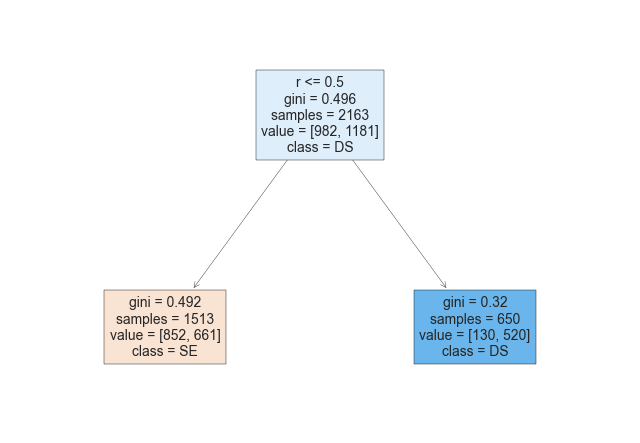

In [12]:
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(stump, feature_names=features, filled=True, 
                   class_names=['SE', 'DS'], fontsize=10)

## Underfit
A stump is too simple. It has too much *bias*.

Solutions:

* Add more features
* Use a more complex model

For a tree we can let it grow deeper which should do both.

## Overfitting

A model is too complicated. It has too much variance.

Solutions:

* Simplify or constrain (*regularize*)
* Add more samples

For a tree we can prune back the growth so that the leaf nodes are overly specific.

In [13]:
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
hi_variance.fit(kag_X_train, kag_y_train)
hi_variance.score(kag_X_test, kag_y_test)

0.6380027739251041

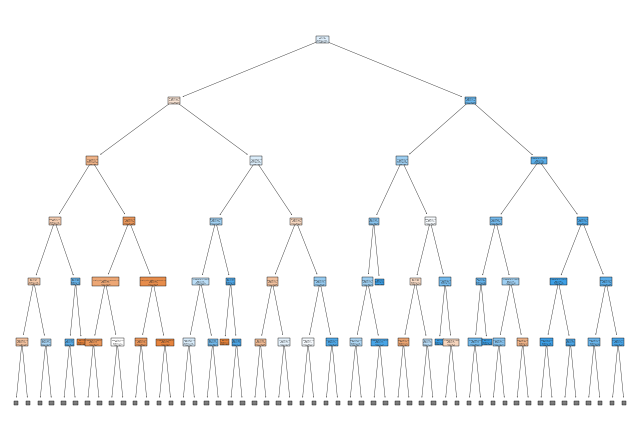

In [14]:
# has over 20 levels, limited to 5
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                   max_depth=5,
                   class_names=['SE', 'DS'])

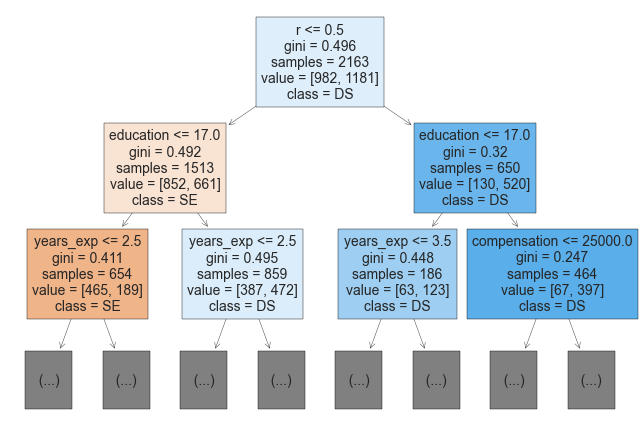

In [15]:
# limit view to first 2
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                   class_names=['SE', 'DS'], max_depth=2, fontsize=10)


## Tree Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* 'max_depth=None' - Tree depth
* 'max_features=None' - Amount of features to examine for split
* 'max_leaf_nodes=None' - Number of leafs
* 'min_impurity_decrease=0' - Split when *impurity* is >= this value. (*Impurity* : 0 - 100% accurate, .3 - 70%. Going from 70% to 100% accurate is a decrease of .3) 
* 'min_samples_leaf=1', - Minimum samples at each leaf.
* 'min_samples_split=2' - Minimum samples required to split a node.
* 'min_weight_fraction_leaf=0' - The fraction fo the total weights required to be a leaf.


In [16]:
stump.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Random Forest

Uses *bagging* to ensemble many trees in an attempt to lower variance.

In [17]:
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(kag_X_train, kag_y_train)
rf.score(kag_X_test, kag_y_test)

0.6726768377253814

In [18]:
len(rf.estimators_)

100

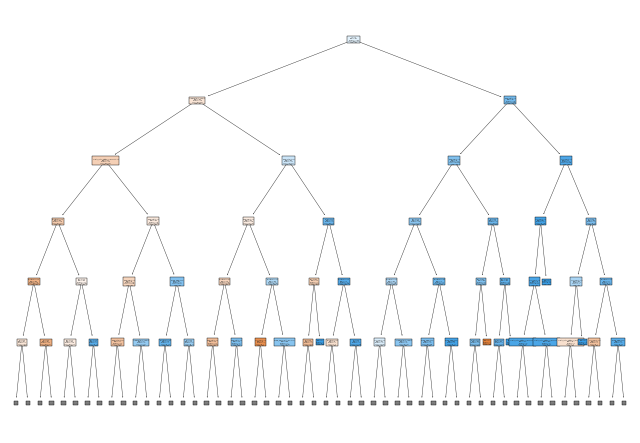

In [19]:
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(rf.estimators_[0], feature_names=features, filled=True, 
                   max_depth=5,
                   class_names=['SE', 'DS'])

## Random Forest Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* 'n_estimators=100' - Number of trees - should be *max_estimators*
* 'oob_score=False' - Can estimate score when training (by using rows that weren't randomly selected). No need to hold out data
* 'warm_start=False' - Can add more trees w/o starting over

From tree:

* 'max_depth=None' - Tree depth (1 to Infinity (`None`))
* 'max_features="sqrt"' - Amount of features to examine for split (1 to number of features (int). Float of percent (0. to 1.0). "log2" log2(n_features) or "sqrt"  sqrt(n_features). (Default square root number of features.)
* 'max_leaf_nodes=None' - Number of leafs. Default (`None`) is unlimited.
* 'min_impurity_decrease=0' - Split when *impurity* is >= this value. (0.0 to 1.0) (*Impurity* : 0 - 100% accurate, .3 - 70%) 
* 'min_samples_leaf=1', - Minimum samples at each leaf. (1 to n_samples).
* 'min_samples_split=2' - Minimum samples required to split a node. (1 to n_samples)
* 'min_weight_fraction_leaf=0' - The fraction (0.0 to 1.0) of the total weights required to be a leaf.

In [20]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot: >

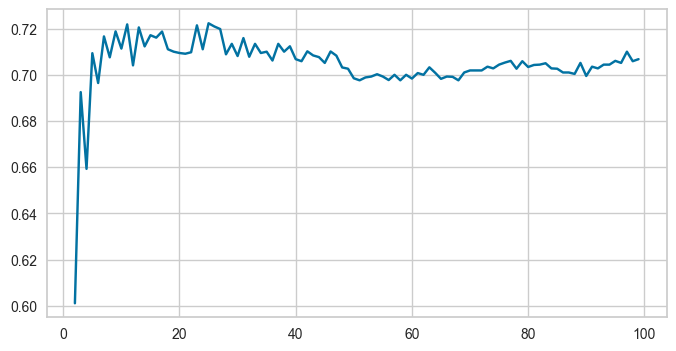

In [21]:
# visualize how changing n_estimators affects score
results = []
rf_ws = ensemble.RandomForestClassifier(random_state=42, warm_start=True, n_estimators=1)
rf_ws.fit(kag_X_train, kag_y_train)
for i in range(2,100):
    rf_ws.set_params(n_estimators=i)
    rf_ws.fit(kag_X_train, kag_y_train)
    # see other metrics
    results.append(metrics.f1_score(kag_y_test, rf_ws.predict(kag_X_test)))
pd.Series(results, index=range(2, 100)).plot(figsize=(8,4))    

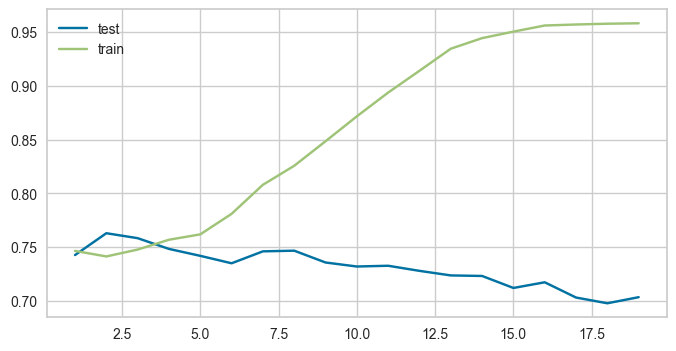

In [22]:
# visualize how changing max_depth affects score
results = []
train_results = []
vals = list(range(1,20))
for i in vals:
    rf_ws = ensemble.RandomForestClassifier(random_state=42, 
                                            max_depth=i)
    rf_ws.fit(kag_X_train, kag_y_train)
    results.append(metrics.f1_score(kag_y_test, rf_ws.predict(kag_X_test)))
    train_results.append(metrics.f1_score(kag_y_train, rf_ws.predict(kag_X_train)))
ax = pd.Series(results, index=vals, name='test').plot(figsize=(8,4))    
pd.Series(train_results, index=vals, name='train').plot(ax=ax)
ax.legend()

## XGBoost

Uses *boosting* to train a series of (weak) trees that try to correct the error of the previous output. (For classification this is mapped to a probability)

Like golfing (you continue to putt or use a different club depending on first error). Decision tree would be a single tee off. Random forest would be averaging the tee offs. 

* Regularization
* Parallel Processing
* Missing Number Support
* Category Support

In [23]:
xg = xgb.XGBClassifier()
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.7087378640776699

In [24]:
# Let's try w/ depth of 2 and 2 trees
xg = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.6546463245492372

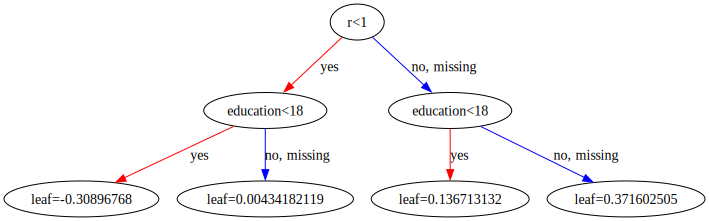

In [25]:
# first tree
# leaf values are log probabilities (*logit*)
xgb.to_graphviz(xg, size='1,1', num_trees=0, fontsize='1')

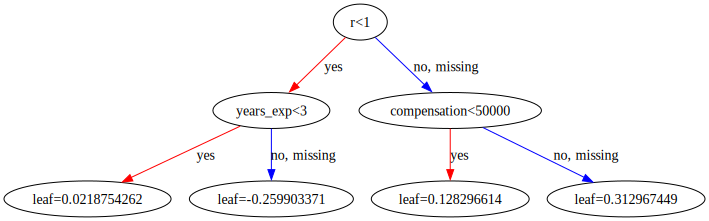

In [26]:
# second tree
xgb.to_graphviz(xg, size='1,1', num_trees=1, fontsize='1')

In [27]:
# let's go down the left path with
# this data
row = pd.Series({'gender_Male': 0.0, 'gender_Prefer_not_to_say': 0.0, 
    'gender_Prefer_to_self-describe': 0.0, 'age': 30.0, 'country_India': 0.0, 
    'country_United_States_of_America': 1.0, 'education': 16.0, 'major_eng': 0.0, 
    'major_other': 0.0, 'major_stat': 0.0, 'years_exp': 0.0, 'compensation': 0.0, 
    'python': 0.0, 'r': 0.0, 'sql': 0.0}).to_frame().T
row

,gender_Male,gender_Prefer_not_to_say,gender_Prefer_to_self-describe,age,country_India,country_United_States_of_America,education,major_eng,major_other,major_stat,years_exp,compensation,python,r,sql
0,0.0,0.0,0.0,30.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# result for DS = .4522
# < .5 ... so Software Engineer!
# this is [prob SE, prob DS]
xg.predict_proba(row)

array([[0.5257493 , 0.47425064]], dtype=float32)

In [29]:
xg.predict(row)

array([0])

(-0.19, 0.45)


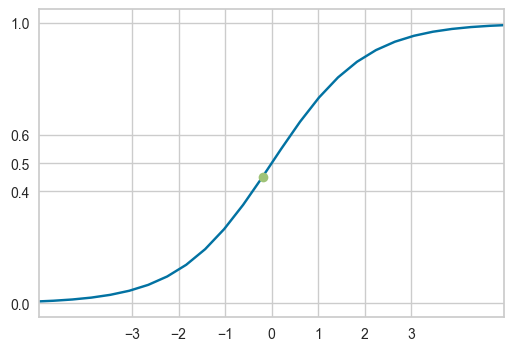

In [30]:
# sum up leafs and throw into 
# Example: no r, low ed, low exp
# -.251 + 0.0602

vals = np.linspace(-10, 10)
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

x = -.251 + 0.0602
y = inv_logit(-.251 + 0.0602)
print(f'({x:.2}, {y:.2})')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(vals, inv_logit(vals))
ax.plot([x], [y], marker='o')
ax.set_xlim([-5, 5])
_ = ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
_ = ax.set_yticks([0,.4, .5, .6, 1])

## Early Stopping
Because you can keep "putting" you can keep track of how far away you are from the hole and stop when you are closest.

In [31]:
# defaults
# 100 putts
xg = xgb.XGBClassifier()
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.7087378640776699

In [32]:
# Early stopping
# Go up to 100 but stop after you haven't improved for 20 hits
# Min value at round 9

xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(kag_X_train, kag_y_train,
       eval_set=[(kag_X_train, kag_y_train),
                 (kag_X_test, kag_y_test)], verbose=10)
xg.score(kag_X_test, kag_y_test)

[0]	validation_0-logloss:0.60947	validation_1-logloss:0.63641
[10]	validation_0-logloss:0.42863	validation_1-logloss:0.57787
[20]	validation_0-logloss:0.37726	validation_1-logloss:0.58201
[30]	validation_0-logloss:0.34016	validation_1-logloss:0.60079
[33]	validation_0-logloss:0.33396	validation_1-logloss:0.60308


0.7018030513176144

In [33]:
xg.best_iteration

13

In [34]:
# we can get the evaluation metrics
# validation_0 is for training data
# validation_1 is for testing data
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6094719315368822,
                0.5641061440971347,
                0.5337894770333572,
                0.5096950750975382,
                0.49263153182815417,
                0.4781443495208667,
                0.4652721662069161,
                0.45379056200433315,
                0.44260194881634474,
                0.4350409703677967,
                0.42862902952326265,
                0.4211854326710539,
                0.4143731927295085,
                0.40792327135856427,
                0.4029539100484775,
                0.39749501368364165,
                0.3912752695778627,
                0.38710792063831445,
                0.3816715271203119,
                0.3794706212619334,
                0.3772551690719564,
                0.37143668586558737,
                0.3661163855687221,
                0.36312861738210245,
                0.3610202571722906,
                0.35692642036833166,
            

Text(0.5, 0, 'ntrees')

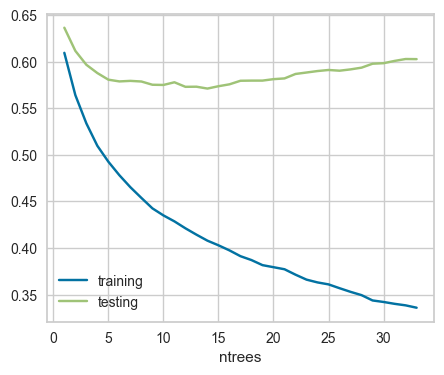

In [35]:
# Testing score is best at 11 trees
results = xg.evals_result()
ax = pd.DataFrame({'training': results['validation_0']['logloss'],
              'testing': results['validation_1']['logloss'],
             }).shift().plot(figsize=(5,4))
ax.set_xlabel('ntrees')

## XGBoost Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* Boosting

  * ``n_estimators=100`` - number of trees (or boosting rounds). Larger is more complex. Default 100. Use ``early_stopping_rounds`` with ``.fit`` to prevent overfitting.

  * ``learning_rate=.3`` (called ``eta`` too) - after each boosting step, shrink feature weights. Larger is more conservative. Can be used with n_estimators to adjust time for convergence [0,1], default .3

  * ``gamma=0`` / ``min_split_loss`` - L0 regularization. Global regularization. Minimum loss required for split. Larger is more conservative. [0, ∞], default 0 - No regularization.


* Regularization

  * ``reg_lambda=1`` - L2 regularization (Root of squared weights). Increase to be more conservative. Default 1
  * ``reg_alpha=0`` - L1 regularization (Mean of weights). Increase to be more conservative. Default 0

* Sampling - Use different rows

  * ``subsample=1`` - Use % of samples (this is rows!) for next boosting round. Lower to more conservative. [0, 1], default 1. (When not equal to 1.0, model does *stochastic gradient descent*, ie. there is some randomness in the model.)


New tree (sampling) parameters - Use different columns (not rows!):

  * ``colsample_bytree=1`` - Fraction of columns for each boosting round.
  
  * ``colsample_bylevel=1`` - Fraction of columns for each depth level.
  
  * ``colsample_bynode=1`` - Fraction of columns for each node.
  

From tree:

  * ``max_depth=6`` - depth of tree. Larger is more complex (more likely to overfit). How many feature interactions you can have. Each level doubles time. [0, ∞], default 6
  * ``min_child_weight=1`` - Stop splitting after certain amount of purity. Larger will be more conservative.


Imbalanced data:

* ``scale_pos_weight=1`` -  ratio negative/positive. Default 1
* Use ``'auc'`` or ``'aucpr'`` for ``eval_metric`` metric (rather than classification default ``'logless'``)
* ``max_delta_step=0`` - try values from 1-10. Default 0





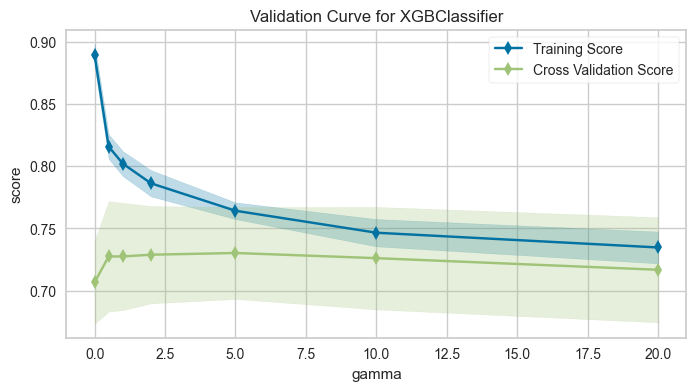

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        g...
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  2. ,  5. , 10. , 20. ]))

In [36]:
# try gamma on xgb
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='gamma', param_range=[0, .5, 1,2,5,10, 20])

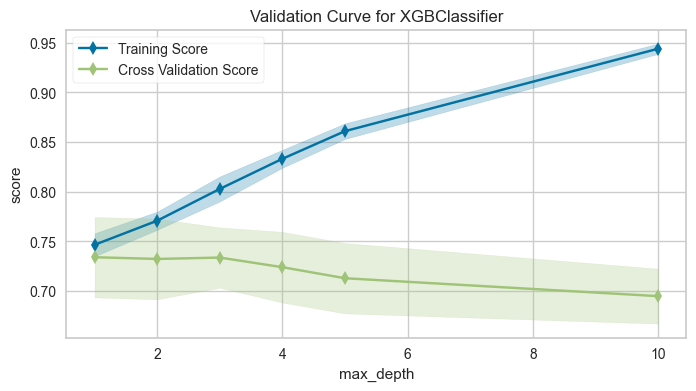

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=No...
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5, 10]))

In [37]:
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='max_depth', param_range=[1,2,3,4,5,10])

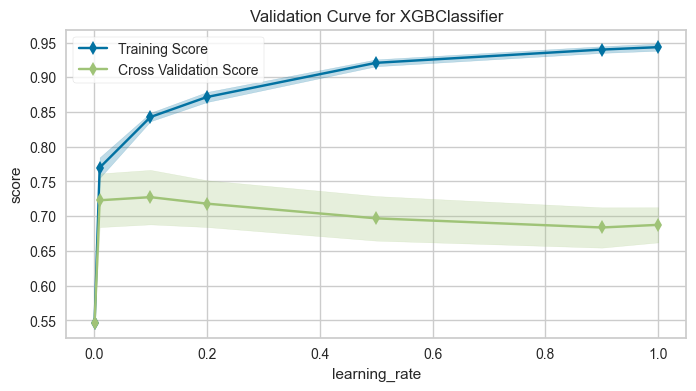

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_type...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]))

In [38]:
# note this depends on n_estimators
# should really use early stopping but yellowbrick doesn't support this 😢
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1])

In [ ]:
params = {'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [ ]:
# this takes a while to run (about 2 minutes)
# can set scoring in GridSearchCV to 
# recall, precision, f1, accuracy
params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative (0 - no shrinkage) 
          #'colsample_bylevel': [.3, 1], # use 0, 50%, or 100% of columns in boost step
          'subsample': [.7, 1],
          #'gamma': [0, 1],
          'max_depth': [1, 2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          #'early_stopping_rounds':[10],
          'n_estimators': [200]}
kag_xgb2 = xgb.XGBClassifier()
cv = (model_selection.GridSearchCV(kag_xgb2, params, cv=3)#, n_jobs=-1)
    .fit(kag_X_train, kag_y_train,
         eval_set=[(kag_X_test, kag_y_test)],
         early_stopping_rounds=5, verbose=10) 
     )

In [ ]:
cv.best_params_

In [39]:
# vs default
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}
xgb_def2 = xgb.XGBClassifier()
xgb_def2.fit(kag_X_train, kag_y_train)

xgb_grid2 = xgb.XGBClassifier(**params)
xgb_grid2.fit(kag_X_train, kag_y_train)
xgb_def2.score(kag_X_test, kag_y_test), xgb_grid2.score(kag_X_test, kag_y_test)

(0.7087378640776699, 0.7281553398058253)

## Bonus: Tuning with Hyperopt


In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score  
#https://bradleyboehmke.github.io/xgboost_databricks_tuning/index.html#slide21
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'reg_alpha': hp.loguniform('alpha', -10, 10),
    'reg_lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 123,
}

In [ ]:
def hyperparameter_tuning(space):    
    model = xgb.XGBClassifier(max_depth = int(space['max_depth']), 
                gamma = space['gamma'],                                         
                reg_alpha = int(space['reg_alpha']),
                min_child_weight=space['min_child_weight'],                                 
                colsample_bytree=space['colsample_bytree'])
    evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
    model.fit(kag_X_train, kag_y_train,
                 eval_set=evaluation, eval_metric="rmse",            
                 early_stopping_rounds=10,verbose=False)    
         
    pred = model.predict(kag_X_test)
    accuracy = accuracy_score(kag_y_test, pred>0.5)    
    print ("SCORE:", accuracy)    
    #change the metric if you like    
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,            
    space=space,           
    algo=tpe.suggest,            
    max_evals=1000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
           )
print (best)

In [ ]:
best # new

In [40]:
hyper_params ={'alpha': 0.19514909424102928,
 'colsample_bytree': 0.8227256149391048,
 'gamma': 0.010701959121627006,
 'lambda': 0.010955985134796302,
 'learning_rate': 0.004570442245136879,
 'max_depth': 3, 
 'min_child_weight': 0.2497193683952876,
 'subsample': 0.6416201529297743}
xgb_hyp = xgb.XGBClassifier(**hyper_params, eval_metric='logloss', 
                            use_label_encoder=False,
                           n_estimators=2_000)
evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
xgb_hyp.fit(kag_X_train, kag_y_train, early_stopping_rounds=10,
           eval_set=evaluation)
xgb_hyp.score(kag_X_test, kag_y_test)#

[0]	validation_0-logloss:0.68796	validation_1-logloss:0.68832
[1]	validation_0-logloss:0.68703	validation_1-logloss:0.68757
[2]	validation_0-logloss:0.68613	validation_1-logloss:0.68678
[3]	validation_0-logloss:0.68529	validation_1-logloss:0.68604
[4]	validation_0-logloss:0.68436	validation_1-logloss:0.68527
[5]	validation_0-logloss:0.68340	validation_1-logloss:0.68445
[6]	validation_0-logloss:0.68246	validation_1-logloss:0.68368
[7]	validation_0-logloss:0.68159	validation_1-logloss:0.68297
[8]	validation_0-logloss:0.68066	validation_1-logloss:0.68221
[9]	validation_0-logloss:0.67995	validation_1-logloss:0.68155
[10]	validation_0-logloss:0.67905	validation_1-logloss:0.68079
[11]	validation_0-logloss:0.67831	validation_1-logloss:0.68023
[12]	validation_0-logloss:0.67740	validation_1-logloss:0.67939
[13]	validation_0-logloss:0.67648	validation_1-logloss:0.67863
[14]	validation_0-logloss:0.67559	validation_1-logloss:0.67796
[15]	validation_0-logloss:0.67491	validation_1-logloss:0.67747
[1

/Users/matt/.envs/menv/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-logloss:0.66148	validation_1-logloss:0.66634
[33]	validation_0-logloss:0.66073	validation_1-logloss:0.66577
[34]	validation_0-logloss:0.66003	validation_1-logloss:0.66508
[35]	validation_0-logloss:0.65945	validation_1-logloss:0.66456
[36]	validation_0-logloss:0.65873	validation_1-logloss:0.66394
[37]	validation_0-logloss:0.65804	validation_1-logloss:0.66336
[38]	validation_0-logloss:0.65732	validation_1-logloss:0.66280
[39]	validation_0-logloss:0.65660	validation_1-logloss:0.66222
[40]	validation_0-logloss:0.65580	validation_1-logloss:0.66161
[41]	validation_0-logloss:0.65525	validation_1-logloss:0.66124
[42]	validation_0-logloss:0.65449	validation_1-logloss:0.66065
[43]	validation_0-logloss:0.65381	validation_1-logloss:0.66000
[44]	validation_0-logloss:0.65308	validation_1-logloss:0.65944
[45]	validation_0-logloss:0.65237	validation_1-logloss:0.65891
[46]	validation_0-logloss:0.65190	validation_1-logloss:0.65854
[47]	validation_0-logloss:0.65118	validation_1-logloss:

[162]	validation_0-logloss:0.59429	validation_1-logloss:0.61319
[163]	validation_0-logloss:0.59393	validation_1-logloss:0.61293
[164]	validation_0-logloss:0.59355	validation_1-logloss:0.61262
[165]	validation_0-logloss:0.59318	validation_1-logloss:0.61230
[166]	validation_0-logloss:0.59281	validation_1-logloss:0.61205
[167]	validation_0-logloss:0.59246	validation_1-logloss:0.61178
[168]	validation_0-logloss:0.59207	validation_1-logloss:0.61140
[169]	validation_0-logloss:0.59174	validation_1-logloss:0.61112
[170]	validation_0-logloss:0.59140	validation_1-logloss:0.61079
[171]	validation_0-logloss:0.59110	validation_1-logloss:0.61052
[172]	validation_0-logloss:0.59073	validation_1-logloss:0.61020
[173]	validation_0-logloss:0.59039	validation_1-logloss:0.60995
[174]	validation_0-logloss:0.59003	validation_1-logloss:0.60960
[175]	validation_0-logloss:0.58973	validation_1-logloss:0.60930
[176]	validation_0-logloss:0.58938	validation_1-logloss:0.60894
[177]	validation_0-logloss:0.58899	valid

[291]	validation_0-logloss:0.55873	validation_1-logloss:0.58710
[292]	validation_0-logloss:0.55851	validation_1-logloss:0.58693
[293]	validation_0-logloss:0.55829	validation_1-logloss:0.58678
[294]	validation_0-logloss:0.55809	validation_1-logloss:0.58657
[295]	validation_0-logloss:0.55787	validation_1-logloss:0.58646
[296]	validation_0-logloss:0.55762	validation_1-logloss:0.58621
[297]	validation_0-logloss:0.55741	validation_1-logloss:0.58606
[298]	validation_0-logloss:0.55719	validation_1-logloss:0.58591
[299]	validation_0-logloss:0.55695	validation_1-logloss:0.58570
[300]	validation_0-logloss:0.55676	validation_1-logloss:0.58557
[301]	validation_0-logloss:0.55654	validation_1-logloss:0.58534
[302]	validation_0-logloss:0.55631	validation_1-logloss:0.58513
[303]	validation_0-logloss:0.55612	validation_1-logloss:0.58503
[304]	validation_0-logloss:0.55590	validation_1-logloss:0.58488
[305]	validation_0-logloss:0.55572	validation_1-logloss:0.58473
[306]	validation_0-logloss:0.55553	valid

[420]	validation_0-logloss:0.53690	validation_1-logloss:0.57302
[421]	validation_0-logloss:0.53676	validation_1-logloss:0.57299
[422]	validation_0-logloss:0.53665	validation_1-logloss:0.57289
[423]	validation_0-logloss:0.53650	validation_1-logloss:0.57275
[424]	validation_0-logloss:0.53638	validation_1-logloss:0.57261
[425]	validation_0-logloss:0.53627	validation_1-logloss:0.57250
[426]	validation_0-logloss:0.53617	validation_1-logloss:0.57243
[427]	validation_0-logloss:0.53608	validation_1-logloss:0.57234
[428]	validation_0-logloss:0.53597	validation_1-logloss:0.57229
[429]	validation_0-logloss:0.53581	validation_1-logloss:0.57219
[430]	validation_0-logloss:0.53572	validation_1-logloss:0.57212
[431]	validation_0-logloss:0.53559	validation_1-logloss:0.57213
[432]	validation_0-logloss:0.53548	validation_1-logloss:0.57205
[433]	validation_0-logloss:0.53532	validation_1-logloss:0.57199
[434]	validation_0-logloss:0.53515	validation_1-logloss:0.57185
[435]	validation_0-logloss:0.53507	valid

[549]	validation_0-logloss:0.52252	validation_1-logloss:0.56358
[550]	validation_0-logloss:0.52245	validation_1-logloss:0.56350
[551]	validation_0-logloss:0.52236	validation_1-logloss:0.56344
[552]	validation_0-logloss:0.52227	validation_1-logloss:0.56345
[553]	validation_0-logloss:0.52218	validation_1-logloss:0.56344
[554]	validation_0-logloss:0.52209	validation_1-logloss:0.56343
[555]	validation_0-logloss:0.52198	validation_1-logloss:0.56333
[556]	validation_0-logloss:0.52190	validation_1-logloss:0.56335
[557]	validation_0-logloss:0.52181	validation_1-logloss:0.56333
[558]	validation_0-logloss:0.52172	validation_1-logloss:0.56327
[559]	validation_0-logloss:0.52160	validation_1-logloss:0.56319
[560]	validation_0-logloss:0.52150	validation_1-logloss:0.56317
[561]	validation_0-logloss:0.52140	validation_1-logloss:0.56310
[562]	validation_0-logloss:0.52130	validation_1-logloss:0.56305
[563]	validation_0-logloss:0.52122	validation_1-logloss:0.56305
[564]	validation_0-logloss:0.52113	valid

[678]	validation_0-logloss:0.51220	validation_1-logloss:0.55873
[679]	validation_0-logloss:0.51212	validation_1-logloss:0.55871
[680]	validation_0-logloss:0.51203	validation_1-logloss:0.55862
[681]	validation_0-logloss:0.51196	validation_1-logloss:0.55857
[682]	validation_0-logloss:0.51190	validation_1-logloss:0.55856
[683]	validation_0-logloss:0.51187	validation_1-logloss:0.55855
[684]	validation_0-logloss:0.51182	validation_1-logloss:0.55853
[685]	validation_0-logloss:0.51175	validation_1-logloss:0.55853
[686]	validation_0-logloss:0.51167	validation_1-logloss:0.55855
[687]	validation_0-logloss:0.51160	validation_1-logloss:0.55855
[688]	validation_0-logloss:0.51152	validation_1-logloss:0.55847
[689]	validation_0-logloss:0.51147	validation_1-logloss:0.55843
[690]	validation_0-logloss:0.51142	validation_1-logloss:0.55836
[691]	validation_0-logloss:0.51135	validation_1-logloss:0.55834
[692]	validation_0-logloss:0.51130	validation_1-logloss:0.55835
[693]	validation_0-logloss:0.51121	valid

0.7253814147018031

In [41]:
xgb_hyp.score(kag_X_test, kag_y_test)

0.7253814147018031

In [42]:
# vs default and grid
xgb_def2.score(kag_X_test, kag_y_test), xgb_grid2.score(kag_X_test, kag_y_test)

(0.7087378640776699, 0.7281553398058253)

In [43]:
grid = xgb_grid2.get_params()
hyp = xgb_hyp.get_params()
for k in grid:
    print(f'{k=:20} grid:{grid[k] or "":20} hyp:{hyp[k] or ""}')

k=objective            grid:binary:logistic      hyp:binary:logistic
k=base_score           grid:                     hyp:
k=booster              grid:                     hyp:
k=callbacks            grid:                     hyp:
k=colsample_bylevel    grid:                     hyp:
k=colsample_bynode     grid:                     hyp:
k=colsample_bytree     grid:                     hyp:0.8227256149391048
k=device               grid:                     hyp:
k=early_stopping_rounds grid:                     hyp:
k=enable_categorical   grid:                     hyp:
k=eval_metric          grid:                     hyp:logloss
k=feature_types        grid:                     hyp:
k=gamma                grid:                     hyp:0.010701959121627006
k=grow_policy          grid:                     hyp:
k=importance_type      grid:                     hyp:
k=interaction_constraints grid:                     hyp:
k=learning_rate        grid:                 0.3 hyp:0.00457044224513687

## Model Evaluation
Now that we've tuned our model, let's look at how it performs

In [44]:
hyper_params ={'alpha': 0.19514909424102928,
 'colsample_bytree': 0.8227256149391048,
 'gamma': 0.010701959121627006,
 'lambda': 0.010955985134796302,
 'learning_rate': 0.004570442245136879,
 'max_depth': 3, 
 'min_child_weight': 0.2497193683952876,
 'subsample': 0.6416201529297743}
xgb_hyp = xgb.XGBClassifier(**hyper_params,
                           n_estimators=2_000)
evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
xgb_hyp.fit(kag_X_train, kag_y_train, early_stopping_rounds=10,
           eval_set=evaluation, verbose=100)

[0]	validation_0-logloss:0.68796	validation_1-logloss:0.68832


/Users/matt/.envs/menv/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.62086	validation_1-logloss:0.63357
[200]	validation_0-logloss:0.58165	validation_1-logloss:0.60337
[300]	validation_0-logloss:0.55676	validation_1-logloss:0.58557
[400]	validation_0-logloss:0.53977	validation_1-logloss:0.57475
[500]	validation_0-logloss:0.52754	validation_1-logloss:0.56678
[600]	validation_0-logloss:0.51822	validation_1-logloss:0.56151
[700]	validation_0-logloss:0.51076	validation_1-logloss:0.55823
[783]	validation_0-logloss:0.50566	validation_1-logloss:0.55573


XGBClassifier(alpha=0.19514909424102928, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8227256149391048, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.010701959121627006,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.010955985134796302,
              learning_rate=0.004570442245136879, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.2497193683952876, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, ...)

In [45]:
metrics.accuracy_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7253814147018031

In [46]:
metrics.precision_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7545691906005222

In [47]:
metrics.recall_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7353689567430025

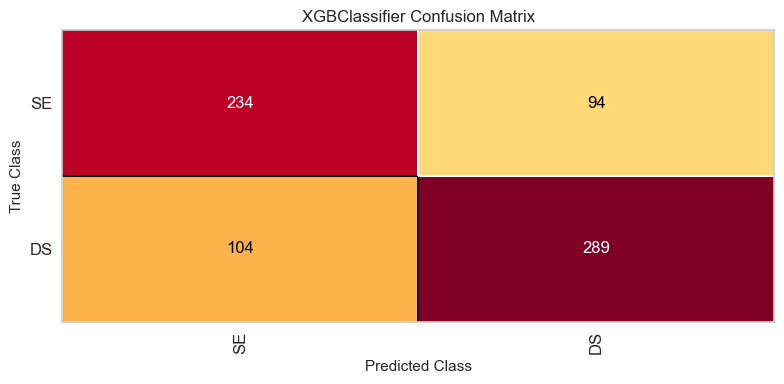

ConfusionMatrix(ax=<AxesSubplot: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['SE', 'DS'],
                cmap=<matplotlib.colors.ListedColormap object at 0x169b27010>,
                estimator=XGBClassifier(alpha=0.19514909424102928,
                                        base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsampl...
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        lambda=0.010955985134796302,
                                        learning_rate=0.004570442245136879,
                                        max_bin=None, max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=3,
                                        max_leaves=None,
                                        min_child_weight=0.2497193683952876,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=2000,
                                        n_jobs=None, ...))

In [48]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.confusion_matrix(xgb_hyp, kag_X_train, kag_y_train,
                            kag_X_test, kag_y_test,
                            classes=['SE', 'DS']
                           )

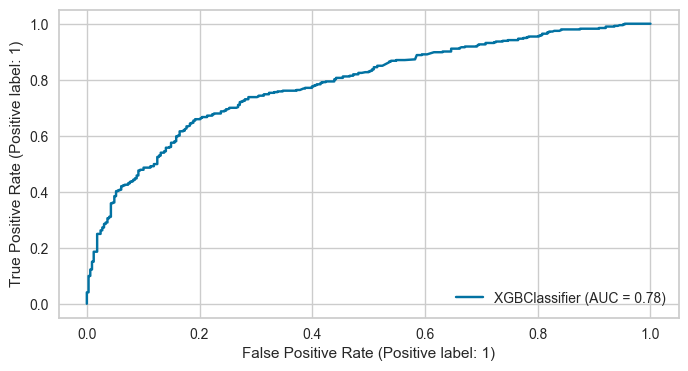

In [49]:
fig, ax = plt.subplots(figsize=(8,4))
metrics.RocCurveDisplay.from_estimator(xgb_hyp,
                       kag_X_test, kag_y_test,ax=ax)

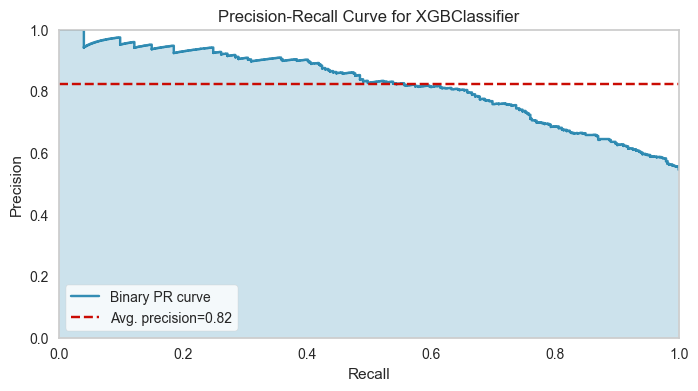

PrecisionRecallCurve(ax=<AxesSubplot: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>,
                     classes=['SE', 'DS'],
                     estimator=XGBClassifier(alpha=0.19514909424102928,
                                             base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.8227256149391048,
                                             device=None,
                                             early_stoppin...
                                             interaction_constraints=None,
                                             lambda=0.010955985134796302,
                                             learning_rate=0.004570442245136879,
                                             max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=3,
                                             max_leaves=None,
                                             min_child_weight=0.2497193683952876,
                                             missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=2000, n_jobs=None, ...),
                     iso_f1_values={0.2, 0.4, 0.6, 0.8}, micro=False)

In [50]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.precision_recall_curve(xgb_hyp, kag_X_train, kag_y_train,
                   kag_X_test, kag_y_test,
                   classes=['SE', 'DS'],
                   micro=False, macro=False
                   )

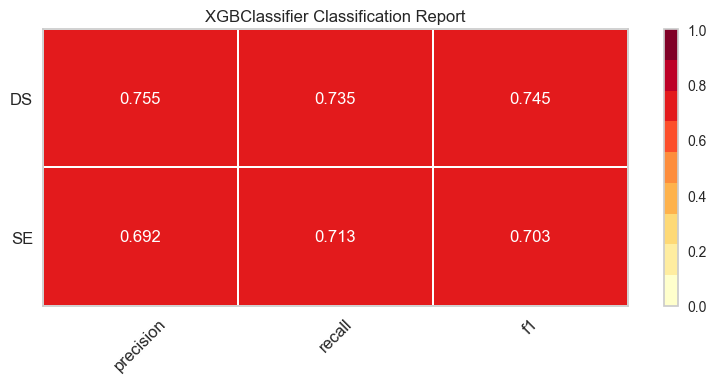

ClassificationReport(ax=<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>,
                     classes=['SE', 'DS'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x172b238e0>,
                     estimator=XGBClassifier(alpha=0.19514909424102928,
                                             base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.8227256149391048,
                                             devic...
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             lambda=0.010955985134796302,
                                             learning_rate=0.004570442245136879,
                                             max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=3,
                                             max_leaves=None,
                                             min_child_weight=0.2497193683952876,
                                             missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=2000, n_jobs=None, ...))

In [51]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.classification_report(xgb_hyp, kag_X_train, kag_y_train,
                   kag_X_test, kag_y_test,
                   classes=['SE', 'DS'],
                   micro=False, macro=False
                   )

## Training For Different Metrics

We tuned our model. But we tuned it against accuracy. What if we want to optimize for recall?

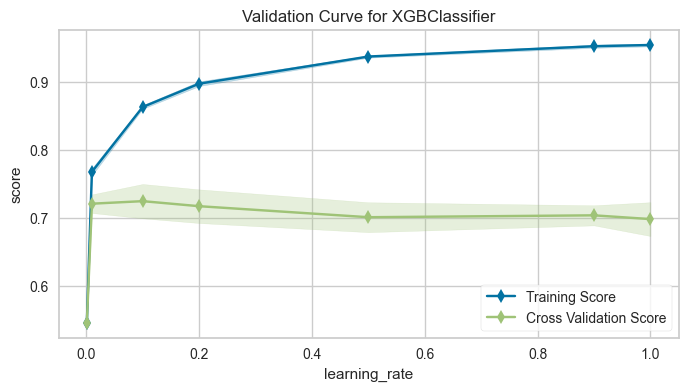

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_type...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]))

In [52]:
# accuracy tuning
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
    #                param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
    )

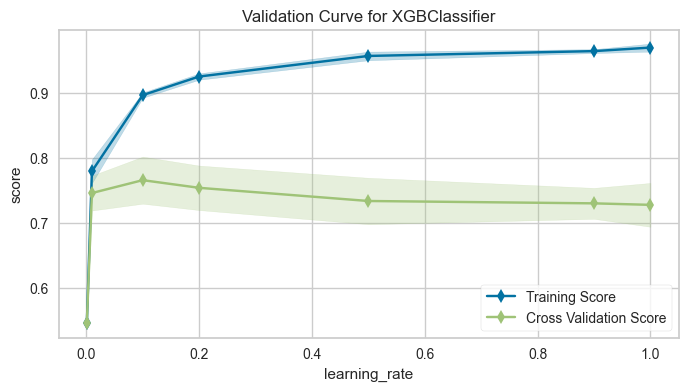

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_type...
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]),
                scoring='precision')

In [53]:
# precision tuning - see scoring param
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
                    scoring='precision',
                    #param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
                   )

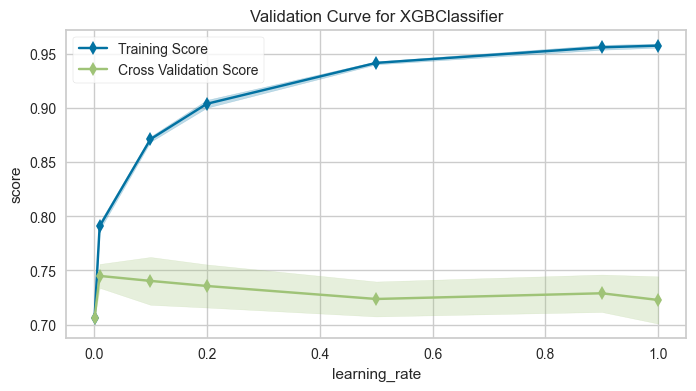

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_type...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]),
                scoring='f1')

In [54]:
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
                    scoring='f1',
                    #param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
                   )

## Model Interpretation

In [55]:
# Trees are great when they overfit... They can explain what they overfit
# (You can use these for "surrogate models")
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
hi_variance.fit(kag_X_train, kag_y_train)
hi_variance.score(kag_X_test, kag_y_test)

0.6352288488210819

<AxesSubplot: >

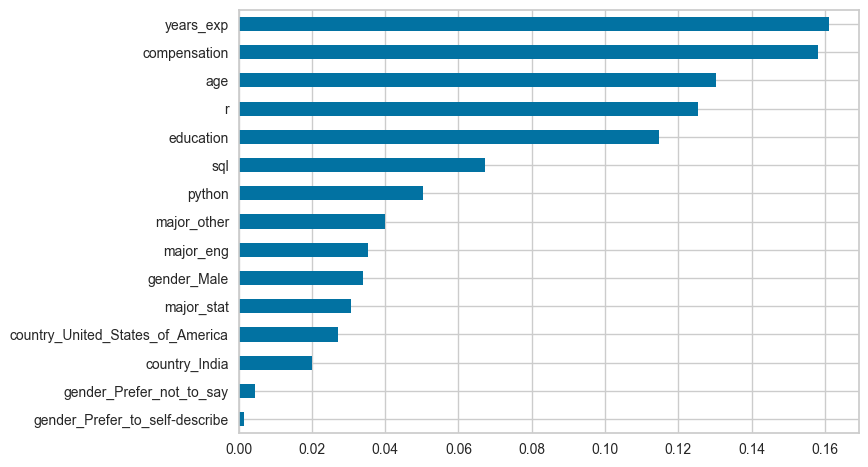

In [56]:
# Feature importance shows the magnitude (not direction) of impact
(pd.Series(hi_variance.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

In [57]:
# XGBoost also supports feature importance
xgb_def = xgb.XGBClassifier()
xgb_def.fit(kag_X_train, kag_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: >

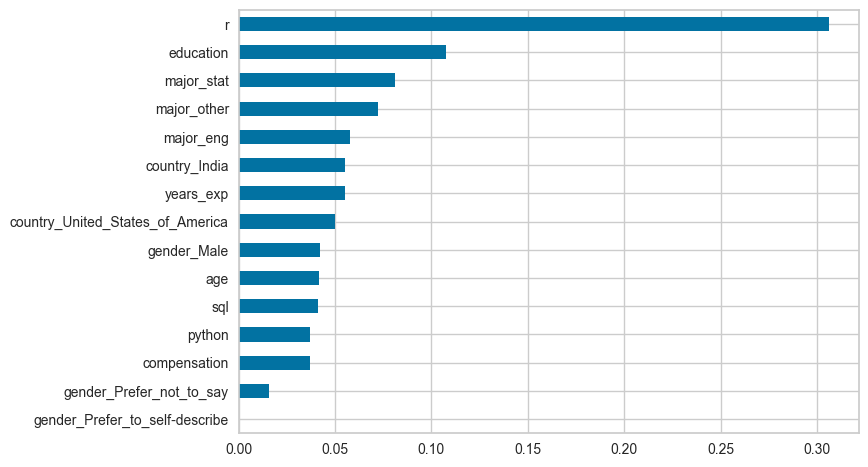

In [58]:
(pd.Series(xgb_def.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

<AxesSubplot: >

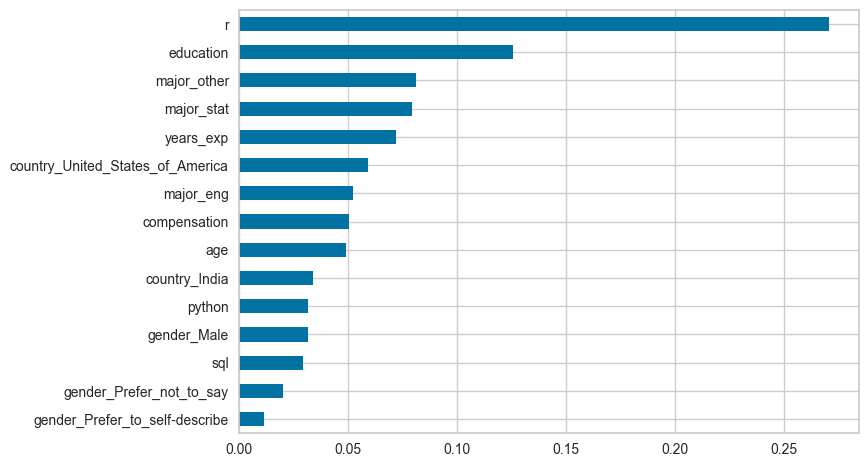

In [59]:
# Feature importance is specific to model/hyperparameters
(pd.Series(xgb_hyp.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

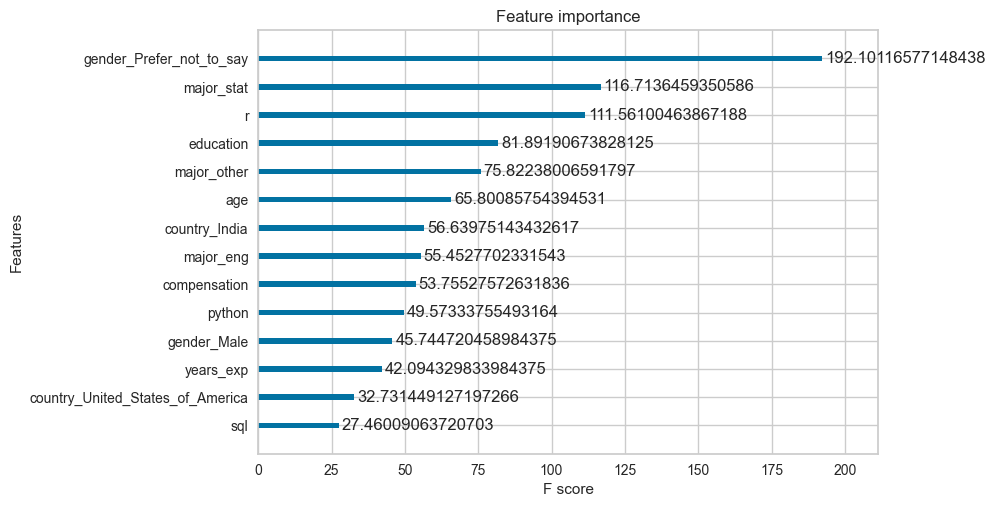

In [60]:
# * "weight" is the number of times a feature appears in a tree
# * "gain" is the average gain of splits which use the feature
# * "cover" is the average coverage of splits which use the feature
xgb.plot_importance(xgb_def, importance_type='cover')

## Bonus: xgbfir (Feature Interactions Reshaped)
 *Gain*: Total gain of each feature or feature interaction
 
 *FScore*: Amount of possible splits taken on a feature or feature Interaction
 
 *wFScore*: Amount of possible splits taken on a feature or feature nteraction weighted by the probability of the splits to take place
 
 *Average wFScore*: wFScore divided by FScore
 
 *Average Gain*: Gain divided by FScore
 
 *Expected Gain*: Total gain of each feature or feature interaction weighted by the probability to gather the gain


In [ ]:
!pip install openpyxl

In [61]:
import xgbfir
xgbfir.saveXgbFI(xgb_def, feature_names=kag_X_train.columns, OutputXlsxFile='fir.xlsx')
pd.read_excel('fir.xlsx')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,years_exp,676.509093,654,87.711477,0.134115,1.034418,132.394676,1,2,3,12,7,3,4.666667,43.642202,3.746177
1,r,574.799398,100,32.752645,0.327526,5.747994,542.616729,2,10,5,3,1,1,3.666667,46.880000,2.850000
2,education,488.017524,242,60.510648,0.250044,2.016601,218.913674,3,4,4,4,2,2,3.166667,42.842975,3.351240
3,compensation,481.768029,696,125.310709,0.180044,0.692195,65.018779,4,1,1,7,13,4,5.000000,47.768678,3.724138
4,age,407.924869,523,114.084793,0.218135,0.779971,58.878736,5,3,2,6,10,5,5.166667,44.070746,3.565966
5,sql,155.485304,200,18.484234,0.092421,0.777427,12.051493,6,5,10,14,11,10,9.333333,43.750000,3.870000
6,major_other,142.320005,105,23.685967,0.225581,1.355429,32.093839,7,8,7,5,4,6,6.166667,39.009524,3.333333
7,major_stat,133.686551,88,32.272883,0.366737,1.519165,31.099962,8,12,6,2,3,7,6.333333,32.136364,2.852273
8,gender_Male,103.457323,130,19.647232,0.151133,0.795826,10.379342,9,7,9,11,9,11,9.333333,39.046154,3.746154
9,country_United_States_of_America,95.768203,102,10.750929,0.105401,0.938904,8.449837,10,9,14,13,8,13,11.166667,45.803922,3.901961


In [62]:
pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,education|r,1305.677983,21,9.188439,0.437545,62.175142,702.473870,1,42,14,8,1,1,11.166667,22.666667,2.000000
1,education|years_exp,1046.363307,125,21.661861,0.173295,8.370906,316.428628,2,5,5,39,3,2,9.333333,40.704000,3.400000
2,compensation|years_exp,503.082455,279,28.607732,0.102537,1.803163,58.451030,3,1,3,61,34,3,17.500000,44.204301,3.971326
3,age|compensation,417.498152,278,50.570080,0.181907,1.501792,46.784174,4,2,1,35,50,5,16.166667,48.924460,3.719424
4,age|years_exp,410.856160,232,40.900325,0.176295,1.770932,57.213843,5,3,2,37,35,4,14.333333,42.900862,3.866379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,country_India|r,0.666255,1,0.038887,0.038887,0.666255,0.025909,86,88,88,83,82,90,86.166667,76.000000,4.000000
86,gender_Prefer_not_to_say|years_exp,0.494118,2,1.373313,0.686657,0.247059,0.335146,87,85,58,5,86,77,66.333333,69.500000,5.000000
87,gender_Prefer_not_to_say|major_stat,0.347635,2,1.743966,0.871983,0.173817,0.286200,88,86,55,2,88,79,66.333333,67.500000,1.500000
88,gender_Prefer_not_to_say|major_other,0.148533,1,0.741085,0.741085,0.148533,0.110076,89,89,72,4,89,85,71.333333,67.000000,4.000000


In [63]:
pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 2')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,education|r|years_exp,2194.572776,28,5.254083,0.187646,78.377599,641.154953,1,20,13,23,2,1,10.000000,22.250000,2.714286
1,compensation|education|years_exp,553.364443,65,6.030636,0.092779,8.513299,89.519204,2,5,10,61,23,4,17.500000,32.507692,3.907692
2,compensation|education|r,545.479628,5,0.822039,0.164408,109.095926,112.566399,3,84,74,29,1,3,32.333333,10.800000,2.000000
3,age|compensation|years_exp,530.652080,171,18.970428,0.110938,3.103229,51.371199,4,1,1,52,59,7,20.666667,45.140351,4.175439
4,education|major_other|years_exp,500.237495,18,1.384031,0.076891,27.790972,48.561142,5,42,59,74,5,8,32.166667,19.944444,3.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,compensation|compensation|gender_Male,23.801212,15,1.939986,0.129332,1.586747,2.866951,96,55,49,43,91,70,67.333333,49.600000,4.133333
96,r|years_exp|years_exp,23.612527,16,2.569156,0.160572,1.475783,0.762642,97,53,32,31,95,96,67.333333,60.937500,4.000000
97,compensation|education|major_other,23.178159,15,2.275372,0.151691,1.545211,1.427835,98,56,39,34,92,89,68.000000,52.933333,3.333333
98,compensation|major_other|major_stat,22.985546,3,0.547310,0.182437,7.661849,7.280684,99,98,81,26,26,33,60.500000,12.666667,5.000000


# SHAP (SHapley Additive exPlantations)
Should be *globally* consistent and accurate

 Shapley value (SHAP).
 
 From game theory, indicates how to distribute attribution of label



In [64]:
import shap
shap.initjs()

# make sure you initialize the js side
shap_ex = shap.TreeExplainer(xgb_def)
vals = shap_ex(kag_X_test)

[16:00:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [65]:
vals

.values =
array([[-0.06511252, -0.00666821,  0.        , ...,  0.18700401,
        -0.57645404, -0.23351651],
       [ 1.0003492 , -0.00458536,  0.        , ..., -0.0588399 ,
         2.2478633 ,  0.01907621],
       [ 0.02119306, -0.00921358,  0.        , ...,  0.36327514,
        -0.62283796, -0.00468408],
       ...,
       [-0.00487527, -0.00884572,  0.        , ..., -0.07550672,
        -0.303425  ,  0.00659669],
       [ 0.00680717, -0.00905723,  0.        , ...,  0.01812378,
        -0.7283013 , -0.05684213],
       [ 0.02840814, -0.00627844,  0.        , ...,  0.10289676,
        -0.42364657,  0.07145351]], dtype=float32)

.base_values =
array([0.22290125, 0.22290125, 0.22290125, 0.22290125, 0.22290125,
       0.22290125, 0.22290125, 0.22290125, 0.22290125, 0.22290125,
       0.22290125, 0.22290125, 0.22290125, 0.22290125, 0.22290125,
       0.22290125, 0.22290125, 0.22290125, 0.22290125, 0.22290125,
       0.22290125, 0.22290125, 0.22290125, 0.22290125, 0.22290125,
       0.22

In [66]:
# Let's explain an individual
kag_X_test.iloc[0]

gender_Male                          True
gender_Prefer_not_to_say            False
gender_Prefer_to_self-describe      False
age                                    30
country_India                       False
country_United_States_of_America    False
education                            16.0
major_eng                           False
major_other                         False
major_stat                          False
years_exp                             5.0
compensation                        50000
python                                  1
r                                       0
sql                                     0
Name: 173, dtype: object

In [67]:
xgb_def.predict(kag_X_test.iloc[[0]])  # predicts SE... why?

array([0])

In [68]:
# label is also SE
kag_y_test.iloc[0]

False

In [69]:
# the base value. We sum up the scores.
# > 0 Positive Case
shap_ex.expected_value

0.22290125

In [70]:
# < 0 therefore ... SE
shap_ex.expected_value + vals.values[0].sum()

-3.0055068

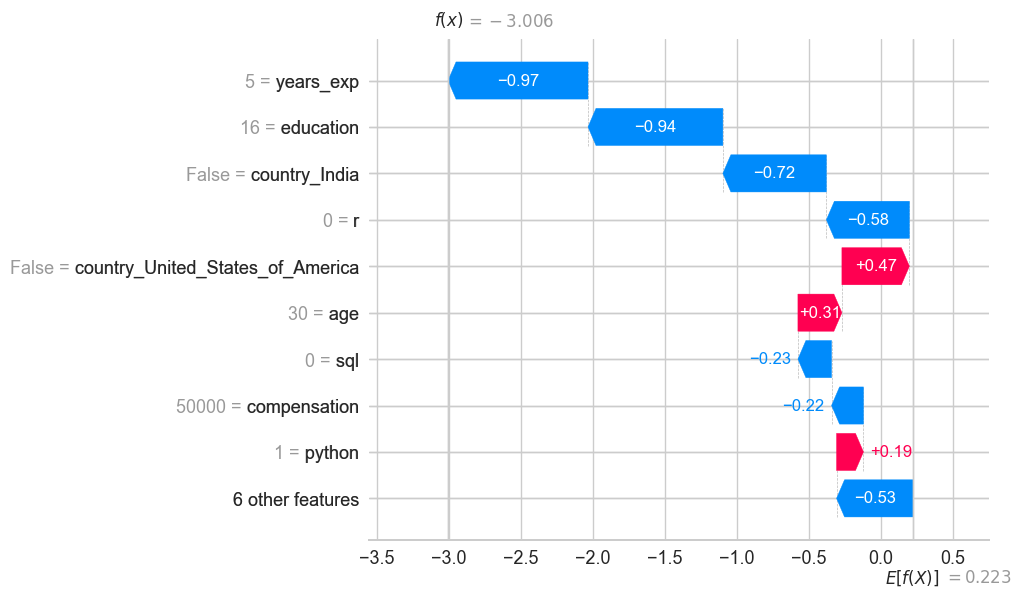

In [71]:
# blue - SE
# red - DS

shap.initjs()
shap.plots.waterfall(vals[0])

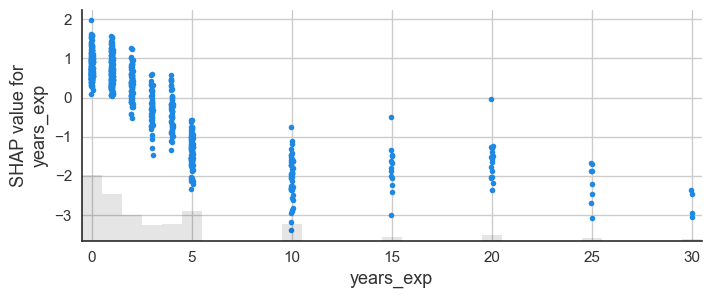

In [72]:
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], ax=ax)

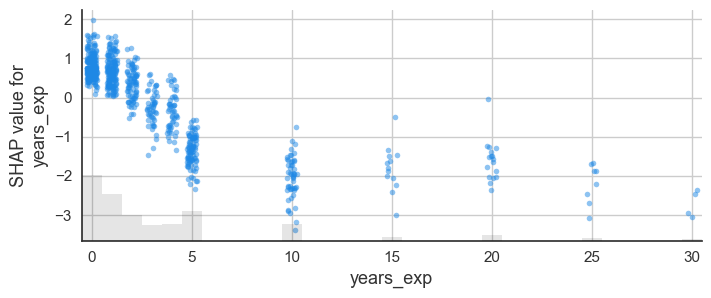

In [73]:
# with jitter/alpha
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], ax=ax, x_jitter=.5, alpha=.5)

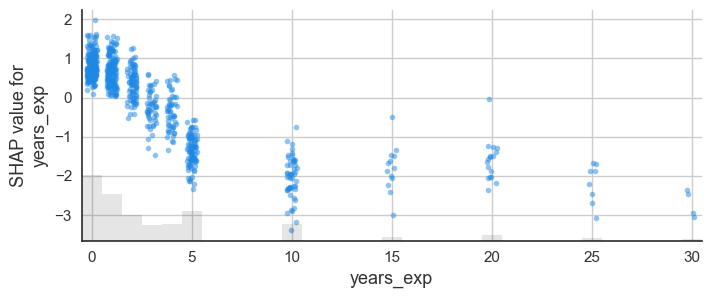

In [74]:
# with jitter/alpha
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], ax=ax, x_jitter=.5, alpha=.5)

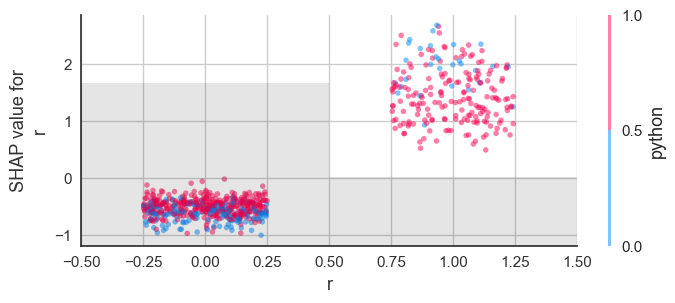

In [75]:
# add interaction (color)
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'r'], color=vals, ax=ax, x_jitter=.5, alpha=.5)

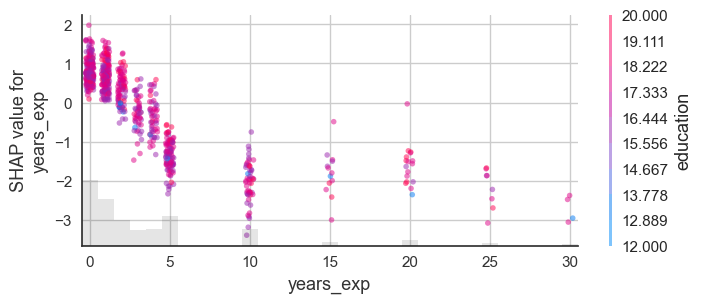

In [76]:
# specify interaction
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], color=vals[:, 'education'], ax=ax, x_jitter=.5, alpha=.5)

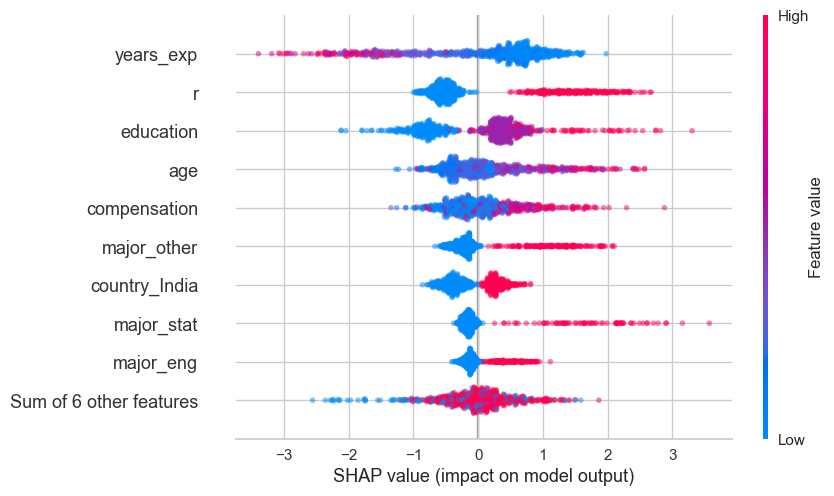

In [77]:
shap.plots.beeswarm(vals, alpha=.5)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'

In [ ]:
!fc-list

# Summary

XGBoost is very powerful. Combining with other tools will take you a long way.

Explore your data and your results.

Lots of libraries. Some are better integrated.

Suggestions:

* Pandas skills come in useful for manipulating data
* Make sure you discuss business value with stake holders


Questions?


Connect on LinkedIn or Twitter `@__mharrison__`

In [79]:
import random
random.randrange(7)

5

In [ ]:
random.randrange(1,5)